In [2]:
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
#pd.set_option('precision', 5) #设置精度
pd.set_option('display.float_format', lambda x: '%.5f' % x) #为了直观的显示数字，不采用科学计数法

# jupyter notebook中设置交互式输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 500)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth', 100)

import sys, gc, os
import matplotlib
import matplotlib.pyplot as plt


# 输出中文字体
#matplotlib.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.sans-serif']=["SimSun"] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.style.use("ggplot")

import faiss
import tensorflow as tf
# from bert4keras.optimizers import Adam
from bert4keras.snippets import DataGenerator, sequence_padding

Using TensorFlow backend.


In [3]:
decay_steps = 1000
lr_sch = tf.keras.experimental.CosineDecay(0.01, decay_steps, alpha=0.1)


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr_sch)

In [2]:
DATA_DIR = '../../data/models/robert_sample_10w_100000_lr2e-05_drop0.2_pt_first-last-avg/epoch0'
os.listdir(DATA_DIR)

['epoch0.weight',
 'query_embedding',
 'doc_embedding',
 'robert.epoch0.lr2e.fla.tar.gz',
 'epoch0.robert.lr2e.drop02.fla.tar.gz']

In [1]:
import sys, os
# 使用混合精度训练
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION']='1'

In [2]:
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION']

'1'

In [2]:
df_all = pd.read_pickle("../../data/raw_data/docs_cut_rm_stop_words.pkl")
df_doc = df_all.query("source=='doc'")
df_dev = df_all.query("source=='dev'")
# df_all.head()
df_pair = pd.read_pickle("../../data/raw_data/train_pairs_cut_rm_stop_words.pkl")
# df_pair.head()

df_dev.head(10)

,index,id,text,text_cut,source
1101500,1101500,200001,甲黄酸阿怕替尼片,"[甲, 黄酸, 阿怕, 替尼片]",dev
1101501,1101501,200002,索泰zbox,"[索泰, zbox]",dev
1101502,1101502,200003,kfc游戏机,"[kfc, 游戏机]",dev
1101503,1101503,200004,bunny成兔粮,"[bunny, 成兔, 粮]",dev
1101504,1101504,200005,铁线威灵仙,"[铁线, 威灵仙]",dev
1101505,1101505,200006,大叶紫檀扬琴,"[大叶, 紫檀, 扬琴]",dev
1101506,1101506,200007,阿no的毛线铺图解,"[阿, no, 的, 毛线, 铺, 图解]",dev
1101507,1101507,200008,充气车库,"[充气, 车库]",dev
1101508,1101508,200009,柴油降凝剂依维柯专用,"[柴油, 降, 凝剂, 依, 维柯, 专用]",dev
1101509,1101509,200010,玻璃胶十大品牌,"[玻璃胶, 十大, 品牌]",dev


In [4]:
df_pair.head(2)

,qid,did,qtext,qtext_cut,dtext,dtext_cut
0,1,679139,美赞臣亲舒一段,"[美赞臣, 亲舒, 一段]",领券满减】美赞臣安婴儿a+亲舒 婴儿奶粉1段850克 0-12个月宝宝,"[领券, 满减, 美赞臣, 安, 婴儿, a, +, 亲舒, 婴儿, 奶粉, 1, 段, 850, 克, 0, 12, 个, 月, 宝宝]"
1,2,35343,慱朗手动料理机,"[慱, 朗, 手动, 料理, 机]",braun/博朗 mq3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机,"[braun, 博朗, mq, 3035, 3000, 5025, 料理, 棒, 手持, 小型, 婴儿, 辅食, 家用, 搅拌机]"


In [48]:
df_pair[~df_pair.qid.isin(val)].shape

(99000, 6)

In [12]:
df_val = df_pair.sample(n=1000, random_state=1234)
df_val["qid"].shape

(1000,)

In [14]:
val = df_val["qid"].tolist()

In [39]:
import json

def write_to_json(jpath, data):
    with open(jpath, 'w', encoding='utf-8') as json_file:
        json.dump(data, json_file, ensure_ascii=False)
        print("write json file success!")
        
def read_json(jpath):
    with open(jpath, 'r', encoding='utf-8') as json_file:
        data = json.load(json_file)
        print("loads json file success!")
        return data

In [45]:
write_to_json("test.json", val)
val2 = read_json("test.json")


write json file success!
loads json file success!


In [46]:
type(val2)

list

In [26]:
def load_embedding(fpath):
    with open(fpath, "r") as f:
        lines = [line.split("\t") for line in f.readlines()]
        index = [line[0] for line in lines]
        emb = [line[1].split(",") for line in lines]
        emb = np.array(emb).astype(np.float32)
        index = np.array(index).astype(np.int32)
    
        return index, emb

In [27]:
qidx, qry_emb = load_embedding(DATA_DIR+"/query_embedding")
didx, doc_emb = load_embedding(DATA_DIR+"/doc_embedding")


In [28]:
didx[-10:]
len(didx)
len(set(didx))

array([1001491, 1001492, 1001493, 1001494, 1001495, 1001496, 1001497,
       1001498, 1001499, 1001500], dtype=int32)

1001500

1001500

In [70]:
doc_emb = doc_emb.astype(np.float32)
qry_emb = qry_emb.astype(np.float32)

In [71]:
use_gpu = False
# IndexFlatL2表示利用L2距离来比较特征的相似度
index_l2 = faiss.IndexFlatL2(128) # 向量维度为128
# 使用GPU
if use_gpu:
    res = faiss.StandardGpuResources()
    gpu_index_l2 = faiss.index_cpu_to_gpu(res, 0, index_l2)

# 倒排索引进行加速
nlist = 100  # 聚类中心的个数
topK = 10  # 召回近邻向量的个数
index_l2 = faiss.IndexIVFFlat(index_l2, 128, nlist, faiss.METRIC_L2)

# 倒排索引加速需要先训练 k近邻
index_l2.train(doc_emb)

In [73]:
# 手动传入向量index
index_l3 = faiss.IndexIDMap(index_l2)
index_l3.add_with_ids(doc_emb, np.array(didx).astype('int64'))

In [80]:
D3, I3 = index_l3.search(qry_emb[0].reshape(-1,128), 50)


In [82]:
# 手动传入向量index
index_l2 = faiss.IndexIDMap(index_l2)

RuntimeError: Error in faiss::IndexIDMapTemplate<IndexT>::IndexIDMapTemplate(IndexT*) [with IndexT = faiss::Index] at /root/miniconda3/conda-bld/faiss-pkg_1641228905850/work/faiss/MetaIndexes.cpp:33: Error: 'index->ntotal == 0' failed: index must be empty on input

In [39]:
index_l2.add_with_ids(doc_emb.astype(np.float32), np.array(didx).astype('int64'))

In [76]:
feature_search = qry_emb[0].reshape(-1,128).astype(np.float32)
feature_search

array([[ 0.115,  0.005,  0.081, -0.081, -0.010, -0.265, -0.029,  0.017,
        -0.042,  0.072, -0.094, -0.104,  0.014,  0.095,  0.056, -0.020,
        -0.016, -0.018, -0.066,  0.071, -0.041,  0.064, -0.112, -0.101,
         0.128,  0.068, -0.004,  0.035,  0.061,  0.011, -0.096, -0.125,
         0.029, -0.027, -0.145, -0.104,  0.058, -0.033, -0.104,  0.145,
         0.091, -0.081,  0.025, -0.133, -0.018,  0.035,  0.125,  0.078,
        -0.147,  0.031,  0.049,  0.070,  0.037,  0.011,  0.016, -0.053,
         0.132,  0.043,  0.010,  0.162, -0.048,  0.073, -0.057, -0.042,
        -0.007,  0.009,  0.041,  0.030,  0.070, -0.023, -0.101,  0.023,
         0.038, -0.104,  0.071,  0.144, -0.230, -0.164, -0.029, -0.140,
        -0.131,  0.075, -0.021,  0.028,  0.063,  0.093,  0.009,  0.072,
         0.090, -0.057, -0.018,  0.029,  0.100, -0.156, -0.189, -0.015,
        -0.074,  0.198, -0.041,  0.101,  0.015,  0.012, -0.040, -0.057,
         0.151, -0.035, -0.085, -0.071, -0.105, -0.051,  0.080, 

In [77]:
# 检索最相似的topK个特征
topK = 50
D, I = index_l2.search(feature_search, topK)
# 返回的D表示相似度（或者距离）, I表示检索的topK个特征id（索引）

In [79]:
I

array([[110541, 900867, 520936, 687601, 997834, 798518, 183180, 204071,
        983544, 538466, 759571, 500347, 637334, 780920, 870317, 865721,
        307254, 622438, 752538, 794021, 863774, 302491, 606865, 878171,
        683417, 746011, 333770, 662078,  91166, 501905, 813744, 302178,
        456839, 311603, 150538,  48118, 387237, 738006, 755943, 431840,
        212325, 666422, 629130, 239125, 347387, 167011, 978371,  63799,
        312866, 596124]])

In [81]:
I3

array([[110542, 900868, 520937, 687602, 997835, 798519, 183181, 204072,
        983545, 538467, 759572, 500348, 637335, 780921, 870318, 865722,
        307255, 622439, 752539, 794022, 863775, 302492, 606866, 878172,
        683418, 746012, 333771, 662079,  91167, 501906, 813745, 302179,
        456840, 311604, 150539,  48119, 387238, 738007, 755944, 431841,
        212326, 666423, 629131, 239126, 347388, 167012, 978372,  63800,
        312867, 596125]])

In [54]:
df_dev[df_dev["id"]==(200000+1)]

,index,id,text,text_cut,source
1101500,1101500,200001,甲黄酸阿怕替尼片,"[甲, 黄酸, 阿怕, 替尼片]",dev


In [87]:
df_doc[df_doc["id"]==110541]

,index,id,text,text_cut,source
110540,110540,110541,聚氨酯材料大小腿假肢脚板 假脚 静踝假脚15cm-27cm 假肢配件,"[聚氨酯, 材料, 大小腿, 假肢, 脚板, 假脚, 静踝, 假脚, 15, cm, 27, cm, 假肢, 配件]",doc


In [55]:
df_doc[df_doc["id"].isin(I)]

,index,id,text,text_cut,source
48118,48118,48119,栢吉堂人工牛黄甲硝唑胶囊0.2g:5mg*12粒/盒,"[栢, 吉, 堂, 人工, 牛黄, 甲硝唑, 胶囊, 0.2, g, 5, mg, 12, 粒, 盒]",doc
63799,63799,63800,咨询下单立减】楚甲盐酸阿莫罗芬搽剂2ml灰指甲敏感真菌感染甲癣,"[咨询, 下, 单立, 减, 楚甲, 盐酸, 阿, 莫罗, 芬搽剂, 2, ml, 灰指甲, 敏感, 真菌, 感染, 甲癣]",doc
91166,91166,91167,甲硝唑片 100片 瓶装滴虫阴道炎甲硝锉片甲硝唑片甲硝锉粉可碾成粉末甲硝锉甲硝唑口服呷哨唑片剂药片甲硝唑片牙疼甲肖唑甲消唑片,"[甲硝唑, 片, 100, 片, 瓶装, 滴虫, 阴道炎, 甲硝, 锉片, 甲硝唑, 片甲, 硝, 锉, 粉, 可, 碾成, 粉末, 甲硝, 锉, 甲硝唑, 口服, 呷, 哨, 唑, 片剂, ...",doc
110541,110541,110542,海尼宝药品丙硫氧嘧啶片50mg*100片/瓶大甲亢甲状腺功能亢进辅助治疗突眼甲状腺肿大手术甲状腺机能亢进,"[海尼宝, 药品, 丙, 硫氧嘧啶, 片, 50, mg, 100, 片, 瓶大, 甲亢, 甲状腺, 功能, 亢进, 辅助, 治疗, 突眼, 甲状腺肿, 大, 手术, 甲状腺, 机能, 亢进]",doc
150538,150538,150539,蒙欣 复方乙酰水杨酸片 100片/瓶,"[蒙欣, 复方, 乙酰, 水杨酸, 片, 100, 片, 瓶]",doc
167011,167011,167012,正品优甲乐 左甲状腺素钠片50ug*100片/盒甲状腺癌单纯性甲状腺肿各种原因引起的甲状腺功能减退甲减优甲片尤甲乐,"[正品, 优甲乐, 左, 甲状腺素, 钠片, 50, ug, 100, 片, 盒, 甲状腺癌, 单纯性, 甲状腺肿, 各种, 原因, 引起, 的, 甲状腺, 功能, 减退, 甲, 减优, 甲片...",doc
183180,183180,183181,pidi/彼迪法莫替丁片20毫克*24片缓解胃酸过多胃痛烧心反酸胃灼热,"[pidi, 彼迪, 法莫替丁, 片, 20, 毫克, 24, 片, 缓解, 胃酸过多, 胃痛, 烧心, 反酸, 胃灼热]",doc
204071,204071,204072,甲硝唑片 华中药业 0.2g*100`s,"[甲硝唑, 片, 华中, 药业, 0.2, g, 100, s]",doc
212325,212325,212326,思美泰丁二磺酸腺苷蛋氨酸肠溶片500mg*10片/盒治疗肝硬化前和肝硬化所致肝内胆汁郁积妊娠期肝内胆汁郁积,"[思美泰丁二, 磺酸, 腺苷, 蛋氨酸, 肠溶片, 500, mg, 10, 片, 盒, 治疗, 肝硬化, 前, 和, 肝硬化, 所致, 肝内, 胆汁, 郁积, 妊娠期, 肝内, 胆汁, 郁积]",doc
239125,239125,239126,5盒低至161/盒 顺丰包邮 思美泰 丁二磺酸腺苷蛋氨酸肠溶片 500mg*10片/盒 适用于肝硬化前和肝硬化所致肝内胆汁淤积,"[5, 盒, 低, 至, 161, 盒, 顺丰, 包邮, 思美泰, 丁二, 磺酸, 腺苷, 蛋氨酸, 肠溶片, 500, mg, 10, 片, 盒, 适用, 于, 肝硬化, 前, 和, 肝硬化...",doc


In [11]:
qids = np.array([3,11,28,60]).reshape(-1,1)

In [12]:
a = np.arange(40).reshape(4,10)
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]])

In [13]:
row_idx, gold_idx = np.where(a==qids)
row_idx
gold_idx

array([0, 1, 2])

array([3, 1, 8])

In [15]:
# topK没找到的query数量
hard_nums = len(qids) - len(row_idx)
hard_nums

1

In [14]:
gold_idx1 = gold_idx+1
gold_idx1

array([4, 2, 9])

In [10]:
(1/gold_idx1).mean()

0.4652777777777778

In [24]:
np.append(1/gold_idx1, [0]*hard_nums).mean()

0.2152777777777778

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np

2022-04-06 21:58:33.570763: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
def plot_scheduler(step, schedulers):
    if not isinstance(schedulers, list):
        schedulers = [schedulers]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 3])
    for scheduler in schedulers:
        ax1.plot(range(step), scheduler(np.arange(step)).numpy(), label="1")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Learning Rate')
        ax1.legend()

        ax2.plot(range(step), scheduler(np.arange(step)).numpy(), label="2")
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Learning Rate')
        ax2.set_yscale('log')
        ax2.legend()
    plt.show()

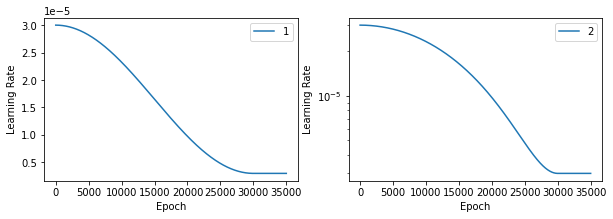

array([2.9999999e-05, 2.9999999e-05, 2.9999999e-05, ..., 2.9999999e-06,
       2.9999999e-06, 2.9999999e-06], dtype=float32)

In [16]:
init_lr = 3e-5
decay_steps = 30000
alpha = 0.1
cos_dec1 = tf.keras.experimental.CosineDecay(init_lr, decay_steps, alpha=alpha)

plot_scheduler(35000, cos_dec1)

cos_dec1(np.arange(35000)).numpy()

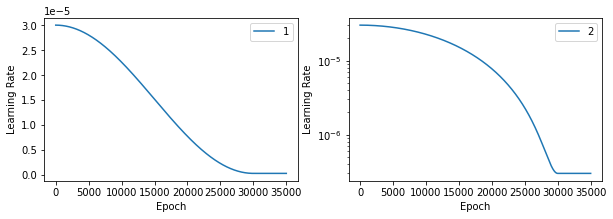

In [12]:
init_lr = 3e-5
decay_steps = 30000
alpha = 0.01
cos_dec2 = tf.keras.experimental.CosineDecay(init_lr, decay_steps, alpha=alpha)

plot_scheduler(35000, cos_dec2)

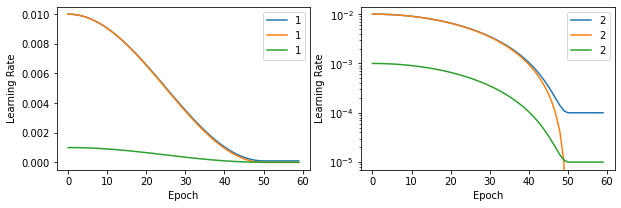

In [5]:
init_lr = 1e-2
decay_steps = 50
alpha = 1e-2
cos_dec1 = tf.keras.experimental.CosineDecay(init_lr, decay_steps, alpha=alpha)

init_lr = 1e-2
decay_steps = 50
alpha = 0
cos_dec2 = tf.keras.experimental.CosineDecay(init_lr, decay_steps, alpha=alpha)

init_lr = 1e-3
decay_steps = 50
alpha = 1e-2
cos_dec3 = tf.keras.experimental.CosineDecay(init_lr, decay_steps, alpha=alpha)

plot_scheduler(60, [cos_dec1, cos_dec2, cos_dec3])